### Contents

Background<br/>
Objective<br/>
Import Libraries<br/>
Import Data<br/>
Data Pre-processing<br/>
Map Ride Share Data <br/>
(Bonus): Additional Analysis<br/>

### Background

In 2018, ride sharing in Canada is estimated to have nearly 2.2M users (1), with revenues estimated at nearly \$500 Million and expected to climb to over $700M by 2022. That is a really interesting growth trajectory.

As someone who is a regular user of ride sharing services, I thought it would be interesting to dive into my own ride sharing behaviour and see if I could use python to uncover key facts about my own trip history in addition to plotting my travel history on a folium map. 

Let's get started!

----


(1) https://www.statista.com/outlook/368/108/ride-sharing/canada#market-revenue

### Objective

This document will outline the following:

1. How to extract your ride sharing data history.
2. How to convert raw address data into latitude and longitudes
3. How to plot the starting and ending trip points on a folium map
4. How to plot routes between your starting and ending points on a folium map. 
5. How to uncover key statistics about your trip history

By the end of the document, you'll be able to have a cool data visualization about your own ride sharing usage history, which should look something like: 

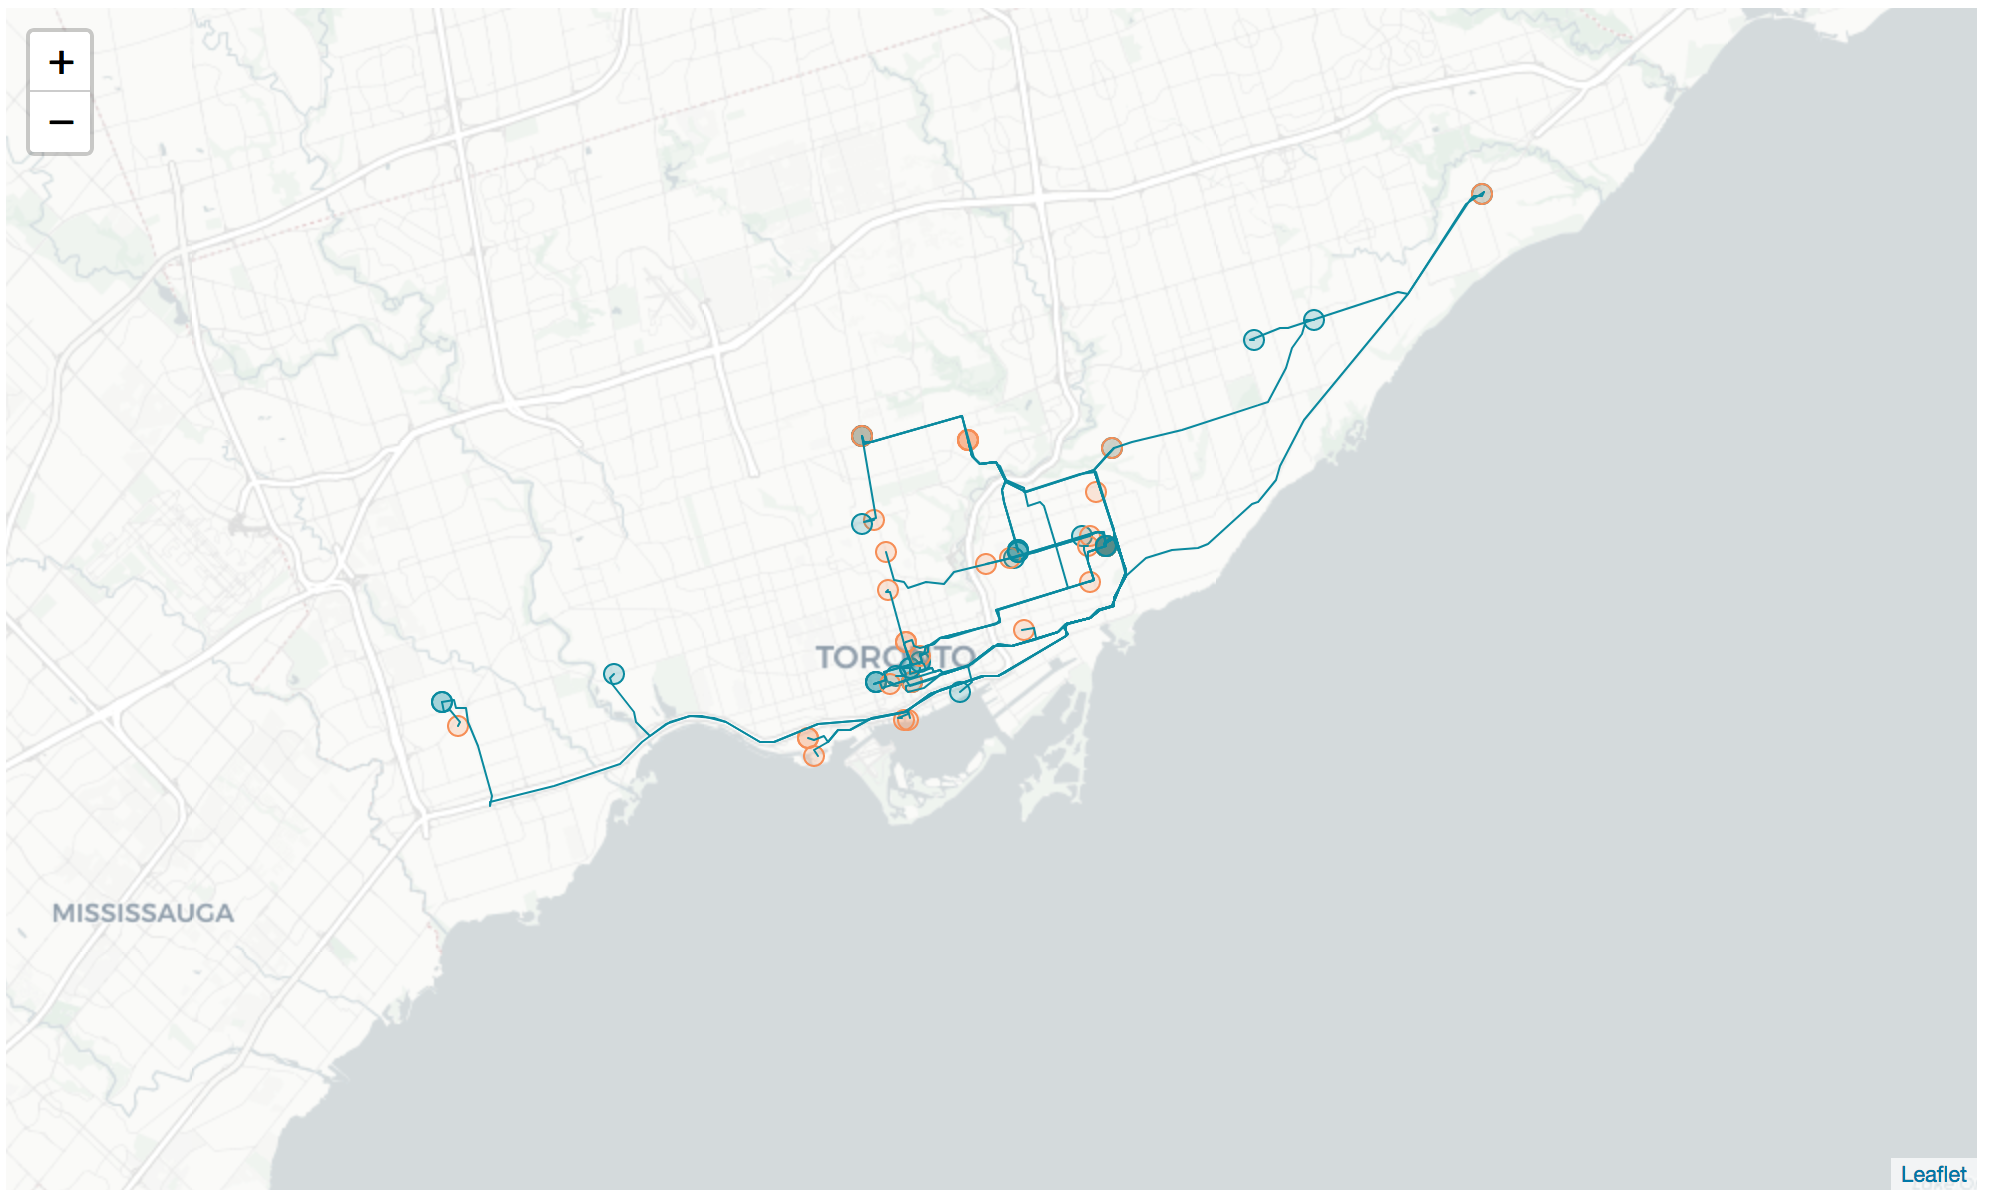

In [1]:
from IPython.display import Image
Image("myridehistory.png")

Let's get started!

### Import Libraries

First thing we need to do is import all of the libraries / modules we'll need to visualize our data on a map.

In [2]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim   # get lat / long of an address
import folium                           # Mapping application
from folium import plugins              # Used to plot routes on a map
import openrouteservice                 # Used to get lat / longs in between starting and ending lat / long
from openrouteservice import convert
import geopy.distance                   # Calculate distance between starting and ending points
% matplotlib inline

### Import Data

In order to get car sharing data, i used the following Chrome extension:
https://ummjackson.github.io/uber-data-extractor/

This data extractor will scrape and export your ride sharing history into a csv. 

In [33]:
# import csv into a dataframe
ride_data = pd.read_csv('trip-history-final.csv')

In [34]:
# information about my ride sharing dataset
ride_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 12 columns):
trip_id           80 non-null object
date              80 non-null object
date_time         80 non-null object
driver            80 non-null object
car_type          80 non-null object
city              80 non-null object
price             74 non-null object
payment_method    10 non-null float64
start_time        80 non-null object
start_address     80 non-null object
end_time          71 non-null object
end_address       71 non-null object
dtypes: float64(1), object(11)
memory usage: 7.6+ KB


In [35]:
pd.set_option('display.max_columns', 500)

In [36]:
# Let's look at the first 5 rows of data
ride_data.head()

,trip_id,date,date_time,driver,car_type,city,price,payment_method,start_time,start_address,end_time,end_address
0,0ae49982-56f5-4c76-a9c0-4357c2b1be62,08/31/18,"Friday, August 31, 2018 10:09 PM",Tarik,UberX,Toronto,CA$10.77,NaN,10:09 PM,"126 Simcoe St, Toronto, ON M5H 0A3, Canada",10:22 PM,"Cumberland St, Toronto, ON, Canada"
1,7af59786-67d3-4435-9e0b-d209c0aec764,08/26/18,"Sunday, August 26, 2018 6:00 PM",Abdul,UberX,Toronto,CA$10.54,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:22 PM,"1095 Yonge St, Toronto, ON M4W 2L8, Canada"
2,625f1e3d-7353-401c-ad68-ab70bcc1caeb,08/25/18,"Saturday, August 25, 2018 8:28 PM",Meri-Ab,UberX,Toronto,CA$4.14,NaN,8:28 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",8:39 PM,"1471 Gerrard St E, Toronto, ON M4L 2A1, Canada"
3,59d0bcc5-a4c7-45a3-97cf-22d0732174ca,08-08-18,"Wednesday, August 8, 2018 6:00 PM",Mussie,UberX,Toronto,CA$18.63,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:25 PM,"Toronto, ON M5E 1Z8, Canada"
4,8da3c19b-ef3e-4476-a300-5b026a68e436,07-07-18,"Saturday, July 7, 2018 9:03 PM",Afolabi,UberX,Toronto,CA$10.49,NaN,9:03 PM,"11 Dockside Dr, Toronto, ON M5A 0B6, Canada",9:35 PM,"3 W Lynn Ave, Toronto, ON M4C, CA"


### Data Pre-processing

What we need to do in order to be able to plot ride history:

1. Filter our data to just rides in Toronto.
2. Get Lat / Longs for each start and end address using <b>geopy</b>
3. Remove any rows that didn't return a starting or ending lat / long
4. Find the Lat / Long paths for every ride in order to plot on a map using <b>openrouteservice</b>

#### Filter data to rides in Toronto

Given that the majority of my rides are in Toronto, let's filter the ride sharing data set to just rides in Toronto.

In [37]:
# Filter data on city = Toronto and store it in a df
toronto_rides = ride_data[ride_data['city'] == 'Toronto'].copy()

# View the data to see that we correctly filtered it.
toronto_rides.head()

,trip_id,date,date_time,driver,car_type,city,price,payment_method,start_time,start_address,end_time,end_address
0,0ae49982-56f5-4c76-a9c0-4357c2b1be62,08/31/18,"Friday, August 31, 2018 10:09 PM",Tarik,UberX,Toronto,CA$10.77,NaN,10:09 PM,"126 Simcoe St, Toronto, ON M5H 0A3, Canada",10:22 PM,"Cumberland St, Toronto, ON, Canada"
1,7af59786-67d3-4435-9e0b-d209c0aec764,08/26/18,"Sunday, August 26, 2018 6:00 PM",Abdul,UberX,Toronto,CA$10.54,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:22 PM,"1095 Yonge St, Toronto, ON M4W 2L8, Canada"
2,625f1e3d-7353-401c-ad68-ab70bcc1caeb,08/25/18,"Saturday, August 25, 2018 8:28 PM",Meri-Ab,UberX,Toronto,CA$4.14,NaN,8:28 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",8:39 PM,"1471 Gerrard St E, Toronto, ON M4L 2A1, Canada"
3,59d0bcc5-a4c7-45a3-97cf-22d0732174ca,08-08-18,"Wednesday, August 8, 2018 6:00 PM",Mussie,UberX,Toronto,CA$18.63,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:25 PM,"Toronto, ON M5E 1Z8, Canada"
4,8da3c19b-ef3e-4476-a300-5b026a68e436,07-07-18,"Saturday, July 7, 2018 9:03 PM",Afolabi,UberX,Toronto,CA$10.49,NaN,9:03 PM,"11 Dockside Dr, Toronto, ON M5A 0B6, Canada",9:35 PM,"3 W Lynn Ave, Toronto, ON M4C, CA"


#### Get Lat / Long for Starting and Ending Address

The first thing we need to do is clean our starting and ending address so that it is in the following format: <br/>
<b>street + ', ' + city + ', ' + country</b>

In [38]:
# Let's first split on ',' and create columns for starting street name, postal country and other.
# We'll start with the starting address.
toronto_rides['start_street'],toronto_rides['start_other'],toronto_rides['start_postal'],toronto_rides['start_country'] = toronto_rides['start_address'].str.split(',', 3).str

In [39]:
# Now let's concatenate the relevant columns into a clean starting address we can use to send to geopy
toronto_rides['start_address_io'] = toronto_rides['start_street'].map(str) + ', ' + toronto_rides['city'] + ', ' + toronto_rides['start_country']

Now let's clean the end address using the same approach.

In [40]:
# Next up, cleaning the ending address of the trip.
toronto_rides['end_street'],toronto_rides['end_other'],toronto_rides['end_postal'],toronto_rides['end_country'] = toronto_rides['end_address'].str.split(',', 3).str

In [41]:
# Now let's concatenate the relevant columns into a clean starting address we can use to send to geopy
toronto_rides['end_address_io'] = toronto_rides['end_street'].map(str) + ', ' + toronto_rides['city'] + ', ' + toronto_rides['end_country']

Let's take a look at the new table.

In [42]:
# Updated table with clean addresses - looks good.
toronto_rides.head()

,trip_id,date,date_time,driver,car_type,city,price,payment_method,start_time,start_address,end_time,end_address,start_street,start_other,start_postal,start_country,start_address_io,end_street,end_other,end_postal,end_country,end_address_io
0,0ae49982-56f5-4c76-a9c0-4357c2b1be62,08/31/18,"Friday, August 31, 2018 10:09 PM",Tarik,UberX,Toronto,CA$10.77,NaN,10:09 PM,"126 Simcoe St, Toronto, ON M5H 0A3, Canada",10:22 PM,"Cumberland St, Toronto, ON, Canada",126 Simcoe St,Toronto,ON M5H 0A3,Canada,"126 Simcoe St, Toronto, Canada",Cumberland St,Toronto,ON,Canada,"Cumberland St, Toronto, Canada"
1,7af59786-67d3-4435-9e0b-d209c0aec764,08/26/18,"Sunday, August 26, 2018 6:00 PM",Abdul,UberX,Toronto,CA$10.54,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:22 PM,"1095 Yonge St, Toronto, ON M4W 2L8, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1095 Yonge St,Toronto,ON M4W 2L8,Canada,"1095 Yonge St, Toronto, Canada"
2,625f1e3d-7353-401c-ad68-ab70bcc1caeb,08/25/18,"Saturday, August 25, 2018 8:28 PM",Meri-Ab,UberX,Toronto,CA$4.14,NaN,8:28 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",8:39 PM,"1471 Gerrard St E, Toronto, ON M4L 2A1, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1471 Gerrard St E,Toronto,ON M4L 2A1,Canada,"1471 Gerrard St E, Toronto, Canada"
3,59d0bcc5-a4c7-45a3-97cf-22d0732174ca,08-08-18,"Wednesday, August 8, 2018 6:00 PM",Mussie,UberX,Toronto,CA$18.63,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:25 PM,"Toronto, ON M5E 1Z8, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",Toronto,ON M5E 1Z8,Canada,NaN,NaN
4,8da3c19b-ef3e-4476-a300-5b026a68e436,07-07-18,"Saturday, July 7, 2018 9:03 PM",Afolabi,UberX,Toronto,CA$10.49,NaN,9:03 PM,"11 Dockside Dr, Toronto, ON M5A 0B6, Canada",9:35 PM,"3 W Lynn Ave, Toronto, ON M4C, CA",11 Dockside Dr,Toronto,ON M5A 0B6,Canada,"11 Dockside Dr, Toronto, Canada",3 W Lynn Ave,Toronto,ON M4C,CA,"3 W Lynn Ave, Toronto, CA"


Next let's create a function we can use to acquire lat / longs from geopy using both the cleaned starting and ending addresses.

In [43]:
def get_latlong(df,address):
    
    '''
    Background: 
    A simple function to query and return a lat / longs from a pre-cleaned list of addresses. 
    This uses geopy. To install simply pip install geopy in your terminal.
    
    Input:
    
    1. df: The dataframe we wish to use
    2. address: The addresss column in the df used to fetch when fetching the lat / long
    
    Output:
    
    1. lat: a list of latitudes based on the addresses provided.
    2. long: a list of longitudes based on the addresses provided.
    '''
    
    # create empty lat / long lists to append our fetched data to.
    lat = []
    long = []
    
    # iterate through the dataframe
    for index, row in df.iterrows():
        
        geolocator = Nominatim(user_agent="my_ride_history_agent", timeout=100)
        
        # determine location based on address 
        location = geolocator.geocode(row[address])
        
        # Some addresses may not be readable, so let's create a rule to append None if they are not readable by geopy
        if location != None:
            
            #append each lat and long to their respective lists.
            lat.append(location.latitude)
            long.append(location.longitude)
            #print(location.latitude) 
            #print(location.longitude) 
        
        else:
            # append None if geopy can't properly process. We could try and fix this later.
            lat.append(None)
            long.append(None)
    
    # Let's see what we've processed
    print(lat)
    print(long)
    
    # return lists of latitudes and longitudes
    return lat,long

Now that we have our formula, let's use it and return lat / longs for our starting address

In [44]:
# get latitudes and longitudes for starting addresses
start_lat,start_long = get_latlong(toronto_rides,'start_address_io')

[43.6491263, 43.68138202, 43.68138202, 43.68138202, 43.645038, 43.68133266, 43.68138202, 43.68138202, 43.668348, 43.68138202, 43.7745579, 43.6801266285714, 43.6801266285714, 43.68133266, 43.6692459473684, 43.6573372, 43.6472995, 43.6424147, 43.6835984762156, 43.6472995, 43.6472995, 43.68133266, 43.7375395, 43.68138202, 43.646925, 43.6495349947368, 43.63971, 43.6784173333333, 43.68133266, 43.68133266, 43.68138202, 43.650817, 43.6796773, 43.68138202, 43.64736955, 43.68138202, 43.68138202, 43.6424147, 43.68133266, 43.7688219, 43.7321651, 43.6798336, 43.6781853666667, 43.7057042, 43.7057042, None, 43.68133266, 43.650817, 43.6878239, 43.7085917, 43.68133266, 43.7085917, 43.7085917, 43.68133266, 43.6526393, 43.68133266, 43.6866471, 43.68133266, None, 43.68138202]
[-79.386993, -79.31522832, -79.31522832, -79.31522832, -79.3655346, -79.31520596, -79.31522832, -79.31522832, -79.397378, -79.31522832, -79.2521288, -79.3451304571429, -79.3451304571429, -79.31520596, -79.3973813157895, -79.3836227,

Let's add these starting lat longs to our toronto_rides df

In [45]:
toronto_rides['start_lat'] = pd.DataFrame({'lat':start_lat})

In [46]:
toronto_rides['start_long'] = pd.DataFrame({'long':start_long})

In [47]:
# Let's see our lat / longs
toronto_rides.head()

,trip_id,date,date_time,driver,car_type,city,price,payment_method,start_time,start_address,end_time,end_address,start_street,start_other,start_postal,start_country,start_address_io,end_street,end_other,end_postal,end_country,end_address_io,start_lat,start_long
0,0ae49982-56f5-4c76-a9c0-4357c2b1be62,08/31/18,"Friday, August 31, 2018 10:09 PM",Tarik,UberX,Toronto,CA$10.77,NaN,10:09 PM,"126 Simcoe St, Toronto, ON M5H 0A3, Canada",10:22 PM,"Cumberland St, Toronto, ON, Canada",126 Simcoe St,Toronto,ON M5H 0A3,Canada,"126 Simcoe St, Toronto, Canada",Cumberland St,Toronto,ON,Canada,"Cumberland St, Toronto, Canada",43.649126,-79.386993
1,7af59786-67d3-4435-9e0b-d209c0aec764,08/26/18,"Sunday, August 26, 2018 6:00 PM",Abdul,UberX,Toronto,CA$10.54,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:22 PM,"1095 Yonge St, Toronto, ON M4W 2L8, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1095 Yonge St,Toronto,ON M4W 2L8,Canada,"1095 Yonge St, Toronto, Canada",43.681382,-79.315228
2,625f1e3d-7353-401c-ad68-ab70bcc1caeb,08/25/18,"Saturday, August 25, 2018 8:28 PM",Meri-Ab,UberX,Toronto,CA$4.14,NaN,8:28 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",8:39 PM,"1471 Gerrard St E, Toronto, ON M4L 2A1, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1471 Gerrard St E,Toronto,ON M4L 2A1,Canada,"1471 Gerrard St E, Toronto, Canada",43.681382,-79.315228
3,59d0bcc5-a4c7-45a3-97cf-22d0732174ca,08-08-18,"Wednesday, August 8, 2018 6:00 PM",Mussie,UberX,Toronto,CA$18.63,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:25 PM,"Toronto, ON M5E 1Z8, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",Toronto,ON M5E 1Z8,Canada,NaN,NaN,43.681382,-79.315228
4,8da3c19b-ef3e-4476-a300-5b026a68e436,07-07-18,"Saturday, July 7, 2018 9:03 PM",Afolabi,UberX,Toronto,CA$10.49,NaN,9:03 PM,"11 Dockside Dr, Toronto, ON M5A 0B6, Canada",9:35 PM,"3 W Lynn Ave, Toronto, ON M4C, CA",11 Dockside Dr,Toronto,ON M5A 0B6,Canada,"11 Dockside Dr, Toronto, Canada",3 W Lynn Ave,Toronto,ON M4C,CA,"3 W Lynn Ave, Toronto, CA",43.645038,-79.365535


Now let's repeat the above steps for and get lat / longs for our ending addresses.

In [48]:
# get latitudes and longitudes for starting addresses
end_lat,end_long = get_latlong(toronto_rides,'end_address_io')

[43.6705274, 43.6799889, 43.67243925, 34.220389, 43.68133266, 34.220389, 43.63798135, 43.660446, None, 43.6573372, None, 43.7073834, 43.7073834, 34.220389, 43.68133266, 43.6692459473684, 43.6573372, 43.68133266, 43.7073834, 43.6811535, 43.68133266, 34.220389, 43.68133266, 43.7375395, 43.68138202, 43.68138202, 43.68133266, 43.68138202, 43.6781998333333, 43.63381345, 43.6380324, 43.68133266, 43.7073834, 43.6765827307692, 43.68138202, 43.6472606, 43.6292015, 43.6366505, 43.64705945, 43.68138202, 43.7688219, 34.220389, 43.68379745, 43.68138202, 43.68138202, 34.220389, 43.7057042, 43.68379745, 43.68138202, 43.6878239, 43.7085917, 43.68138202, 43.68138202, 43.7085917, 43.68133266, 43.6539472, 43.68133266, 43.6946010333333, 43.68138202, 43.63381345]
[-79.3899064, -79.3905802, -79.32075005, 70.3800314, -79.31520596, 70.3800314, -79.384778234903, -79.3434588, None, -79.3836227, None, -79.3626552, -79.3626552, 70.3800314, -79.31520596, -79.3973813157895, -79.3836227, -79.31520596, -79.3626552, -

In [49]:
# Let's add the ending lat longs to our toronto_rides df
toronto_rides['end_lat'] = pd.DataFrame({'lat':end_lat})
toronto_rides['end_long'] = pd.DataFrame({'lat':end_long})

Let's view our updated toronto_rides df with starting and ending latitudes and longitudes.

In [50]:
toronto_rides.head()

,trip_id,date,date_time,driver,car_type,city,price,payment_method,start_time,start_address,end_time,end_address,start_street,start_other,start_postal,start_country,start_address_io,end_street,end_other,end_postal,end_country,end_address_io,start_lat,start_long,end_lat,end_long
0,0ae49982-56f5-4c76-a9c0-4357c2b1be62,08/31/18,"Friday, August 31, 2018 10:09 PM",Tarik,UberX,Toronto,CA$10.77,NaN,10:09 PM,"126 Simcoe St, Toronto, ON M5H 0A3, Canada",10:22 PM,"Cumberland St, Toronto, ON, Canada",126 Simcoe St,Toronto,ON M5H 0A3,Canada,"126 Simcoe St, Toronto, Canada",Cumberland St,Toronto,ON,Canada,"Cumberland St, Toronto, Canada",43.649126,-79.386993,43.670527,-79.389906
1,7af59786-67d3-4435-9e0b-d209c0aec764,08/26/18,"Sunday, August 26, 2018 6:00 PM",Abdul,UberX,Toronto,CA$10.54,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:22 PM,"1095 Yonge St, Toronto, ON M4W 2L8, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1095 Yonge St,Toronto,ON M4W 2L8,Canada,"1095 Yonge St, Toronto, Canada",43.681382,-79.315228,43.679989,-79.390580
2,625f1e3d-7353-401c-ad68-ab70bcc1caeb,08/25/18,"Saturday, August 25, 2018 8:28 PM",Meri-Ab,UberX,Toronto,CA$4.14,NaN,8:28 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",8:39 PM,"1471 Gerrard St E, Toronto, ON M4L 2A1, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1471 Gerrard St E,Toronto,ON M4L 2A1,Canada,"1471 Gerrard St E, Toronto, Canada",43.681382,-79.315228,43.672439,-79.320750
3,59d0bcc5-a4c7-45a3-97cf-22d0732174ca,08-08-18,"Wednesday, August 8, 2018 6:00 PM",Mussie,UberX,Toronto,CA$18.63,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:25 PM,"Toronto, ON M5E 1Z8, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",Toronto,ON M5E 1Z8,Canada,NaN,NaN,43.681382,-79.315228,34.220389,70.380031
4,8da3c19b-ef3e-4476-a300-5b026a68e436,07-07-18,"Saturday, July 7, 2018 9:03 PM",Afolabi,UberX,Toronto,CA$10.49,NaN,9:03 PM,"11 Dockside Dr, Toronto, ON M5A 0B6, Canada",9:35 PM,"3 W Lynn Ave, Toronto, ON M4C, CA",11 Dockside Dr,Toronto,ON M5A 0B6,Canada,"11 Dockside Dr, Toronto, Canada",3 W Lynn Ave,Toronto,ON M4C,CA,"3 W Lynn Ave, Toronto, CA",43.645038,-79.365535,43.681333,-79.315206


#### Remove any rows that didn't return a lat / long

In order to plot our lat / longs on a map, all of the data needs to have a latitude and longitude. If they do not, we'll just remove them from our df.

In [51]:
# remove starting lat longs = None
toronto_rides = toronto_rides[np.isfinite(toronto_rides['start_lat'])]
toronto_rides = toronto_rides[np.isfinite(toronto_rides['start_long'])]

# remove ending lat longs = None
toronto_rides = toronto_rides[np.isfinite(toronto_rides['end_lat'])]
toronto_rides = toronto_rides[np.isfinite(toronto_rides['end_long'])]

In [52]:
# I noticed that there was some end_address_io that was NaN, but setting a lat long. Let's remove those rows too. 
toronto_rides.dropna(subset=['end_address_io'],inplace=True)
toronto_rides.dropna(subset=['start_address_io'],inplace=True)

In [53]:
toronto_rides.head()

,trip_id,date,date_time,driver,car_type,city,price,payment_method,start_time,start_address,end_time,end_address,start_street,start_other,start_postal,start_country,start_address_io,end_street,end_other,end_postal,end_country,end_address_io,start_lat,start_long,end_lat,end_long
0,0ae49982-56f5-4c76-a9c0-4357c2b1be62,08/31/18,"Friday, August 31, 2018 10:09 PM",Tarik,UberX,Toronto,CA$10.77,NaN,10:09 PM,"126 Simcoe St, Toronto, ON M5H 0A3, Canada",10:22 PM,"Cumberland St, Toronto, ON, Canada",126 Simcoe St,Toronto,ON M5H 0A3,Canada,"126 Simcoe St, Toronto, Canada",Cumberland St,Toronto,ON,Canada,"Cumberland St, Toronto, Canada",43.649126,-79.386993,43.670527,-79.389906
1,7af59786-67d3-4435-9e0b-d209c0aec764,08/26/18,"Sunday, August 26, 2018 6:00 PM",Abdul,UberX,Toronto,CA$10.54,NaN,6:00 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",6:22 PM,"1095 Yonge St, Toronto, ON M4W 2L8, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1095 Yonge St,Toronto,ON M4W 2L8,Canada,"1095 Yonge St, Toronto, Canada",43.681382,-79.315228,43.679989,-79.390580
2,625f1e3d-7353-401c-ad68-ab70bcc1caeb,08/25/18,"Saturday, August 25, 2018 8:28 PM",Meri-Ab,UberX,Toronto,CA$4.14,NaN,8:28 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",8:39 PM,"1471 Gerrard St E, Toronto, ON M4L 2A1, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",1471 Gerrard St E,Toronto,ON M4L 2A1,Canada,"1471 Gerrard St E, Toronto, Canada",43.681382,-79.315228,43.672439,-79.320750
4,8da3c19b-ef3e-4476-a300-5b026a68e436,07-07-18,"Saturday, July 7, 2018 9:03 PM",Afolabi,UberX,Toronto,CA$10.49,NaN,9:03 PM,"11 Dockside Dr, Toronto, ON M5A 0B6, Canada",9:35 PM,"3 W Lynn Ave, Toronto, ON M4C, CA",11 Dockside Dr,Toronto,ON M5A 0B6,Canada,"11 Dockside Dr, Toronto, Canada",3 W Lynn Ave,Toronto,ON M4C,CA,"3 W Lynn Ave, Toronto, CA",43.645038,-79.365535,43.681333,-79.315206
6,9934a4c8-dcaa-49bb-b6de-c06388245671,07-07-18,"Saturday, July 7, 2018 5:22 PM",Mohammad,UberX,Toronto,CA$13.73,NaN,5:22 PM,"5 W Lynn Ave, Toronto, ON M4C 3V7, Canada",5:57 PM,"245 Queens Quay W, Toronto, ON M5J 2K9, Canada",5 W Lynn Ave,Toronto,ON M4C 3V7,Canada,"5 W Lynn Ave, Toronto, Canada",245 Queens Quay W,Toronto,ON M5J 2K9,Canada,"245 Queens Quay W, Toronto, Canada",43.681382,-79.315228,43.637981,-79.384778


In [54]:
toronto_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 59
Data columns (total 26 columns):
trip_id             43 non-null object
date                43 non-null object
date_time           43 non-null object
driver              43 non-null object
car_type            43 non-null object
city                43 non-null object
price               43 non-null object
payment_method      0 non-null float64
start_time          43 non-null object
start_address       43 non-null object
end_time            43 non-null object
end_address         43 non-null object
start_street        43 non-null object
start_other         43 non-null object
start_postal        43 non-null object
start_country       43 non-null object
start_address_io    43 non-null object
end_street          43 non-null object
end_other           43 non-null object
end_postal          43 non-null object
end_country         43 non-null object
end_address_io      43 non-null object
start_lat           43 non-null float64

It looks like I have 43 trips to work with and visualize.

#### Let's calculate the distance between starting and ending points

In [55]:
def get_distance(df):
    
    distance_travelled = []
    
    for index, row in df.iterrows():
        
        coords_1 = (row['start_lat'], row['start_long'])
        coords_2 = (row['end_lat'], row['end_long'])
        distance_km = geopy.distance.vincenty(coords_1, coords_2).km
        distance_travelled.append(distance_km)
        
    return distance_travelled

In [56]:
distance_travelled = get_distance(toronto_rides)

In [57]:
len(distance_travelled)

43

In [58]:
toronto_rides['distance'] = pd.DataFrame({'distance':distance_travelled})

#### Clean Trip Cost Data

In [60]:
toronto_rides['price_clean'] = toronto_rides['price'].str[3:]

In [61]:
toronto_rides['price_clean'] = toronto_rides['price_clean'].apply(pd.to_numeric, errors='coerce')

### Map Ride Share Data

Ok, now on to the fun stuff. Let's start visualizing our car history on a map. 

Couple things we need to do:

1. Plot starting (blue) and ending (orange) lat long on the map. 
2. Plot the paths between the starting and ending points on the map.

In order to plot the paths, we'll need to query the openrouteservice (2) api to return all of the lat / longs in between the starting and ending points. You'll need to register and generate an api key before your can use this yourself.

----

(2) https://openrouteservice.org/dev/#/signup



#### Plot starting and ending points on the map

In order to efficiently do this, let's create a function to help accomplish this. For more details about folium, you can visit this link: http://python-visualization.github.io/folium/quickstart.html

In [64]:
def generate_map(map_location, map_style, start_lat_col, start_long_col, start_color, end_lat_col, end_long_col, end_color):
    
    """
    
    Background:
    This function will return a folium map with starting and ending trip location markers. 
    
    Inputs:
    
    map_location: This is where you want to set the default location for the map. Format: [lat_value,long_value]
    map_style: The style of map you want to render. I am using "cartodbpositron" style.
    start_lat_col: Column where your trip starting latitude points are.
    start_long_col: Column where your trip starting longitude points are.
    start_color: The color of the starting circle you want to render on the folium map.
    end_lat_col: Column where your trip ending latitude points are.
    end_long_col: Column where your trip ending longitude points are.
    end_color: The color of the ending circle you want to render on the folium map.
    
    Outputs:
    
    folium_map: This is the folium map we created.
    
    
    """

    # generate a new map
    folium_map = folium.Map(location=map_location,
                            zoom_start=11,
                            tiles=map_style)

    # for each row in the data, add a cicle marker
    for index, row in toronto_rides.iterrows():
        
        # add starting location markers to the map
        folium.CircleMarker(location=(row[start_lat_col],
                                      row[start_long_col]),
                            color=start_color,
                            radius=5,
                            weight=1,
                            fill=True).add_to(folium_map)
        
        # add end location markers to the map
        folium.CircleMarker(location=(row[end_lat_col],
                                      row[end_long_col]),
                            color=end_color,
                            radius=5,
                            weight=1,
                            fill=True).add_to(folium_map)
        
    return folium_map

In [65]:
# Let's add the starting and ending lat longs to the folium map using the function we just built.
generate_map([43.6813629, -79.315015],"cartodbpositron","start_lat","start_long",'#0A8A9F',"end_lat","end_long",'#f68e56')

#### Plot the paths between starting and ending trip points on the map

Let's create a function which will access the openrouteservice api and return all of the latitudes and longitudes between our starting and ending trip points. 

<b>Important Note:</b> The openrouteservice api exports are reversed (long, lat) vs. what folium uses (lat,long). We'll need to reverse the lat / longs before we can plot the coordinates on a folium map.

For more information about the openrouteservice api please visit: <br/>
https://github.com/GIScience/openrouteservice-py

In [66]:
def get_paths(df):
    
    """
    Background:
    This function will return all of the paths / routes in latitudes and longitudes in between our starting and ending trip points.
    
    Inputs:
    
    df: The dataframe you wish to pass in.
    
    Outputs:
    
    path_list: A list of lat long tuples for each trip. 
    
    """
    
    path_list = []
    
    for index, row in df.iterrows():
        
        # I included try / except as a precaution in case any paths are extremely long, which we'll skip. 
        # I noticed this exception error when I accidentally generated a lat / long for no address. Be aware of this and remove prior to using this function. 
        try:
            # coordinates of the trips living within specific table columns.
            coords = ((row['start_long'],row['start_lat']),(row['end_long'],row['end_lat']))
            
            # Specify your personal API key
            client = openrouteservice.Client(key='5b3ce3597851110001cf6248583fb50713a447e9b97fbdf819f805ee') 
            geometry = client.directions(coords)['routes'][0]['geometry']
            decoded = convert.decode_polyline(geometry)
            
            # We need to reverse the long / lat output from results so that we can graph lat / long
            reverse = [(y, x) for x, y in decoded['coordinates']]        
            
            # Append each route to the path_list list
            path_list.append(reverse)
            
            # confirmation of each route being processed. Feel free to comment out.
            print(index)
            
        except:
            pass
        
    return path_list
    

In [67]:
# Let's store all of the path lat long data into routes. We'll pass this data into another function below. 
routes = get_paths(toronto_rides)

0
1
2
4
6
7
9
11
12
16
17
18
19
20
22
25
27
28
29
30
31
32
33
34
35
36
37
38
39
40
44
46
47
49
50
51
53
54
55


In [68]:
len(routes)

39

It looks like the openrouteservice api returned 39 routes. We'll have to investigate why a few did not return.

In [69]:
toronto_rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 59
Data columns (total 28 columns):
trip_id             43 non-null object
date                43 non-null object
date_time           43 non-null object
driver              43 non-null object
car_type            43 non-null object
city                43 non-null object
price               43 non-null object
payment_method      0 non-null float64
start_time          43 non-null object
start_address       43 non-null object
end_time            43 non-null object
end_address         43 non-null object
start_street        43 non-null object
start_other         43 non-null object
start_postal        43 non-null object
start_country       43 non-null object
start_address_io    43 non-null object
end_street          43 non-null object
end_other           43 non-null object
end_postal          43 non-null object
end_country         43 non-null object
end_address_io      43 non-null object
start_lat           43 non-null float64

Nice! We now have all of the lat / long paths in between all of our starting and ending points. Let's create a function to plot these paths on a folium map. 

In [70]:
def plot_paths(paths,map_data):
    
    """
    Background:
    This function will take all of the paths generated from get_paths(df) and add them to our folium map.
    
    Input:
    
    paths: Our list of paths we generated from get_paths(df)
    map_data: Our map we generated using the generate_map() function
    
    Output:
    
    map_data: Our map with all of our routes plotted!
    
    """
    
    # Loop through all of our paths and add each of them to our map.
    
    for path in paths:
        
        line = folium.PolyLine(
            path,
            weight=1,
            color='#0A8A9F'
        ).add_to(map_data)
    
    return map_data
       

#### Let's generate the final map!

Alright, we have all our our points and paths. Let's call a couple functions and generate our final map!

In [71]:
map_data = generate_map([43.6813629, -79.315015],"cartodbpositron","start_lat","start_long",'#0A8A9F',"end_lat","end_long",'#f68e56')

In [72]:
plot_paths(routes, map_data)

<b>Success!</b> Now all of our routes are plotted on a map. \o/

### (Bonus): Additional Analysis

As a bonus, let's take a look at the following:

1. Mean cost of a ride
2. Mean distance of a trip
3. Relationship between costs and trip distance

####  Mean cost of a ride.

For this analysis, we'll just look at toronto_rides in its current form as I'd like to compare cost to distance travelled.

In [73]:
toronto_rides['price_clean'].mean()

15.013720930232562

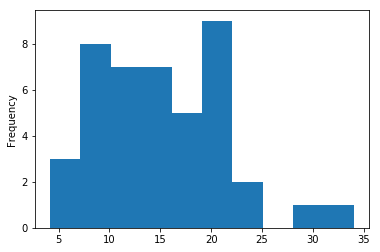

In [74]:
toronto_rides['price_clean'].plot(kind='hist')

#### Distance

It appears that some calculations of distance were NaN, we'll need to filter these out. 

In [75]:
toronto_analysis = toronto_rides[toronto_rides['distance']<1000].copy()

In [76]:
len(toronto_analysis)

30

It appears only 30 distances were calculated using geopy.

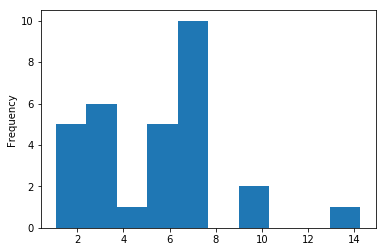

In [78]:
toronto_analysis['distance'].plot(kind='hist')

In [79]:
toronto_analysis['distance'].mean()

5.538018193936126

#### Relationship between price and distance

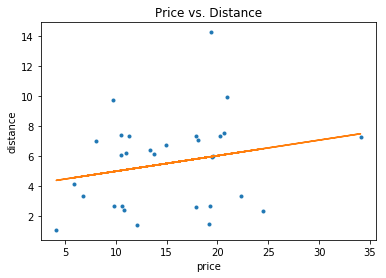

In [83]:
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

# Sample data
x = toronto_analysis['price_clean']
y = toronto_analysis['distance']

# Fit with polyfit
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.title("Price vs. Distance")
plt.xlabel("price")
plt.ylabel("distance")
plt.show()

While we do see as distance increases, so does price. But keep in mind this is only among 30 trips. 

In [85]:
toronto_analysis['price_clean'].corr(toronto_analysis['distance'])

0.22419849223283644